In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
from datetime import date
import pandas_datareader as web
import warnings
warnings.filterwarnings("ignore")

# xgboost
from xgboost import XGBRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from pickle import dump, load

In [3]:
start = dt.datetime(2021,10,1)
end = dt.datetime(2022,6,30)

# Extract Crypto Price

In [4]:
#read crypto pricing
#extract data from yahoo finance
MANA = web.DataReader('MANA-USD','yahoo', start, end)
ENJ = web.DataReader('ENJ-USD','yahoo', start, end)
RACA = web.DataReader('RACA-USD','yahoo', start, end)
ETH = web.DataReader('ETH-USD','yahoo', start, end)
BTC = web.DataReader('BTC-USD','yahoo', start, end)
BNB = web.DataReader('BNB-USD','yahoo', start, end)

In [5]:
MANA = MANA.reset_index()
ENJ = ENJ.reset_index()
RACA = RACA.reset_index()
ETH = ETH.reset_index()
BTC = BTC.reset_index()
BNB = BNB.reset_index()

In [6]:
def convert_date(data):
    data.date = pd.to_datetime(data.date)
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    #data.columns = data.columns.str.replace('Date', 'date')
    return data

In [7]:
MANA.columns = MANA.columns.str.replace('Date', 'date')
ENJ.columns = ENJ.columns.str.replace('Date', 'date')
RACA.columns = RACA.columns.str.replace('Date', 'date')
ETH.columns = ETH.columns.str.replace('Date', 'date')
BTC.columns = BTC.columns.str.replace('Date', 'date')
BNB.columns = BNB.columns.str.replace('Date', 'date')

MANA = convert_date(MANA)
ENJ = convert_date(ENJ)
RACA = convert_date(RACA)
ETH = convert_date(ETH)
BTC = convert_date(BTC)
BNB = convert_date(BNB)

In [8]:
#add pct change column to capture daily crypto price change
ClosingPrice = MANA[['Adj Close']]
MANA['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = BTC[['Adj Close']]
BTC['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = ETH[['Adj Close']]
ETH['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = BNB[['Adj Close']]
BNB['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = ENJ[['Adj Close']]
ENJ['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = RACA[['Adj Close']]
RACA['pct_change'] = ClosingPrice.pct_change()*100

MANA = MANA.set_index('date')
BTC = BTC.set_index('date')
ETH = ETH.set_index('date')
BNB = BNB.set_index('date')
ENJ = ENJ.set_index('date')
RACA = RACA.set_index('date')

# Load sentiment score for forbes and coindesk news

In [10]:
forbes_news = pd.read_csv(r"Data/text_data/Forbes_News_sentiment.csv", sep="\t")
coindesk_init_news = pd.read_csv(r"Data/text_data/CoinDesk_News_sentiment.csv", sep="\t")

In [11]:
def filter_news_sentiment(start, end, data):
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    crypto_news = data[(data['category'] == 'Cryptocurrencies')].reset_index()
    stocks_market_news = data[(data['category'] == 'Stock Market')].reset_index()
    finance_news = data[(data['category'] == 'Finance')].reset_index()
    #metaverse_news = data[(data['category'] == 'Metaverse')].reset_index()
    
    crypto_news = split_news_category(crypto_news)
    stocks_market_news = split_news_category(stocks_market_news)
    finance_news = split_news_category(finance_news)
    #metaverse_news = split_news_category(metaverse_news, remove_pos_bias, remove_neg_bias)
    
    return crypto_news,stocks_market_news,finance_news

In [12]:
def split_news_category(data):
    #group daily sentiment score
    data = data.drop(['content'], axis=1)
    data = data.groupby(['date'])['sentiment_score'].mean().reset_index().rename(columns={'mean':'sentiment score'})
    data = data.set_index('date') 
    data = data.sort_index() # sort by datetime
    data = data.reset_index()
    
    data = data.set_index('date')
    
    data["sentiment_score_1"] = data.shift(1)
    return data

In [15]:
def filter_coindesk_news_sentiment(start, end, data):
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    data = split_news_category(data)
    
    return data

In [13]:
start_sentiment = dt.datetime(2021,10,1)
end_sentiment = dt.datetime(2022,6,30)

In [16]:
crypto_news, stocks_market_news, finance_news = filter_news_sentiment(start, end, forbes_news)
coindesk_news = filter_coindesk_news_sentiment(start, end, coindesk_init_news)

#remove all the sentiment score left only between -0.5 above or more than 0.5
positive = 0.3
negative = -0.3

crypto_news_filter = crypto_news[(crypto_news['sentiment_score'] > positive) | (crypto_news['sentiment_score'] < negative)]
stocks_market_news_filter = stocks_market_news[(stocks_market_news['sentiment_score'] > positive) | (stocks_market_news['sentiment_score'] < negative)]
finance_news_filter = finance_news[(finance_news['sentiment_score'] > positive) | (finance_news['sentiment_score'] < negative)]
coindesk_news_filter = coindesk_news[(coindesk_news['sentiment_score'] > positive) | (coindesk_news['sentiment_score'] < negative)]


# Generated RSI

In [17]:
# Calculate the RSI via pandas_ta
MANA_7_RSI = MANA.ta.rsi(close='Adj Close', length=7, append=True,signal_indicators=True)
MANA_14_RSI = MANA.ta.rsi(close='Adj Close', length=14, append=True,signal_indicators=True)

In [18]:
def pandas_rsi(df: pd.DataFrame, window_length: int = 14, output: str = None, price: str = 'adj close'):
    """
    An implementation of Wells Wilder's RSI calculation as outlined in
    his 1978 book "New Concepts in Technical Trading Systems" which makes
    use of the α-1 Wilder Smoothing Method of calculating the average
    gains and losses across trading periods and the Pandas library.
    @author: https://github.com/alphazwest
    Args:
        df: pandas.DataFrame - a Pandas Dataframe object
        window_length: int - the period over which the RSI is calculated. Default is 14
        output: str or None - optional output path to save data as CSV
        price: str - the column name from which the RSI values are calcuated. Default is 'Close'
    Returns:
        DataFrame object with columns as such, where xxx denotes an inconsequential
        name of the provided first column:
            ['xxx', 'diff', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi']
    """
    # Calculate Price Differences using the column specified as price.
    df['diff'] = df['adj close'].diff(1)

    # Calculate Avg. Gains/Losses
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)

    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Calculate Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length

    # Calculate Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length

    # Calculate RS Values
    df['rs'] = df['avg_gain'] / df['avg_loss']

    # Calculate RSI
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))

    # Save if specified
    if output is not None:
        df.to_csv(output)

    return 

In [19]:
MANA.columns = map(str.lower, MANA.columns)
# Make RSI Calculations
pandas_rsi(df=MANA, window_length=14, price='adj close')

ENJ.columns = map(str.lower, ENJ.columns)
# Make RSI Calculations
pandas_rsi(df=ENJ, window_length=14, price='adj close')

RACA.columns = map(str.lower, RACA.columns)
# Make RSI Calculations
pandas_rsi(df=RACA, window_length=14, price='adj close')

BTC.columns = map(str.lower, BTC.columns)
# Make RSI Calculations
pandas_rsi(df=BTC, window_length=14, price='adj close')

ETH.columns = map(str.lower, ETH.columns)
# Make RSI Calculations
pandas_rsi(df=ETH, window_length=14, price='adj close')

BNB.columns = map(str.lower, BNB.columns)
# Make RSI Calculations
pandas_rsi(df=BNB, window_length=14, price='adj close')

# XGBoost prediction model

In [20]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [21]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [22]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    #dump(model,open('Models/predictive/{0}_model.pkl'.format(crypto),'wb'))
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]
 

In [23]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        #print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# MANA

In [24]:
def plot_prediction_result(values, var):
    # transform the time series data into supervised learning
    data = series_to_supervised(values, n_in=var)
    # evaluate
    mae, y, yhat = walk_forward_validation(data, 200)
    print('MAE: %.3f' % mae)
    # plot expected vs preducted
    pyplot.plot(y, label='Expected')
    pyplot.plot(yhat, label='Predicted')
    pyplot.legend()
    pyplot.show()

MAE: 0.194


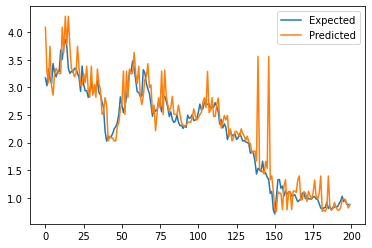

In [25]:
values=MANA[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [30]:
mana_merge_data = pd.DataFrame({ 
                            'open': MANA['open'],
                            'rsi': MANA['rsi'],
                            'rs': MANA['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'finance_sentiment': finance_news.sentiment_score,
                            'coindesk_sentiment': coindesk_news.sentiment_score,
                            'adj close': MANA['adj close']
                          })

MAE: 0.103


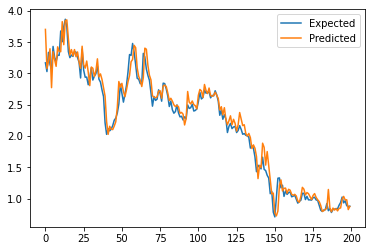

In [31]:
values=mana_merge_data[['rsi', 'rs', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

MAE: 0.173


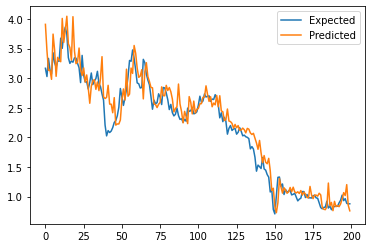

In [33]:
values=mana_merge_data[['crypto_sentiment','stock_market_sentiment','finance_sentiment','coindesk_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

# ENJ

MAE: 0.122


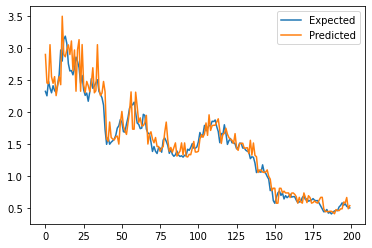

In [34]:
values=ENJ[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [35]:
enj_merge_data = pd.DataFrame({ 
                            'open': ENJ['open'],
                            'rsi': ENJ['rsi'],
                            'rs': ENJ['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'finance_sentiment': finance_news.sentiment_score,
                            'coindesk_sentiment': coindesk_news.sentiment_score,
                            'adj close': ENJ['adj close']
                          })

MAE: 0.112


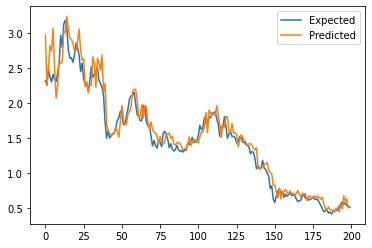

In [36]:
values=enj_merge_data[['crypto_sentiment','stock_market_sentiment','finance_sentiment','coindesk_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

# RACA

MAE: 0.000


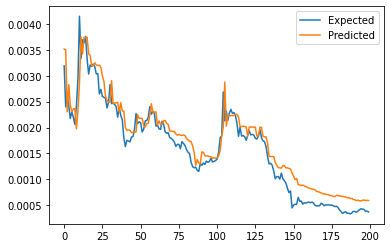

In [44]:
values=RACA[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [45]:
raca_merge_data = pd.DataFrame({ 
                            'open': RACA['open'],
                            'rsi': RACA['rsi'],
                            'rs': RACA['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'finance_sentiment': finance_news.sentiment_score,
                            'coindesk_sentiment': coindesk_news.sentiment_score,
                            'adj close': RACA['adj close']
                          })

MAE: 0.000


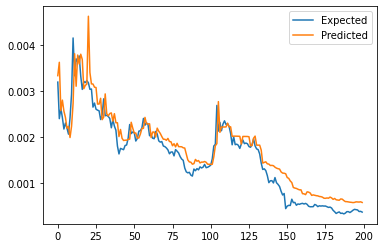

In [46]:
values=raca_merge_data[['crypto_sentiment','stock_market_sentiment','finance_sentiment','coindesk_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

# BTC

MAE: 1412.196


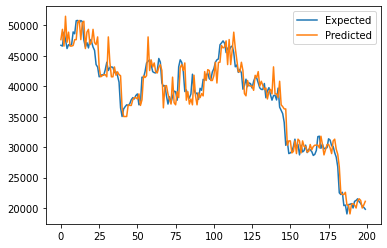

In [47]:
values=BTC[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [48]:
btc_merge_data = pd.DataFrame({ 
                            'open': BTC['open'],
                            'rsi': BTC['rsi'],
                            'rs': BTC['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'finance_sentiment': finance_news.sentiment_score,
                            'coindesk_sentiment': coindesk_news.sentiment_score,
                            'adj close': BTC['adj close']
                          })

MAE: 1324.763


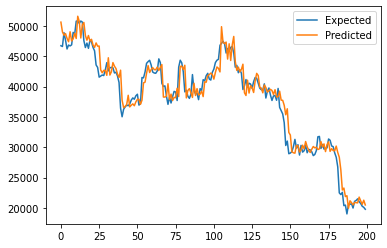

In [49]:
values=btc_merge_data[['crypto_sentiment','stock_market_sentiment','finance_sentiment','coindesk_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

# ETH

MAE: 132.605


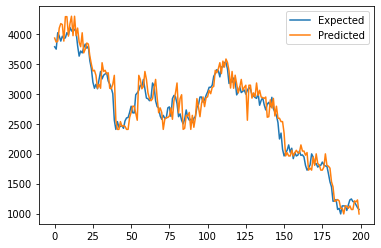

In [50]:
values=ETH[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [51]:
eth_merge_data = pd.DataFrame({ 
                            'open': ETH['open'],
                            'rsi': ETH['rsi'],
                            'rs': ETH['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'finance_sentiment': finance_news.sentiment_score,
                            'coindesk_sentiment': coindesk_news.sentiment_score,
                            'adj close': ETH['adj close']
                          })

MAE: 124.704


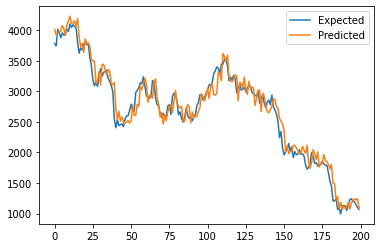

In [52]:
values=eth_merge_data[['crypto_sentiment','stock_market_sentiment','finance_sentiment','coindesk_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

# BNB

MAE: 17.420


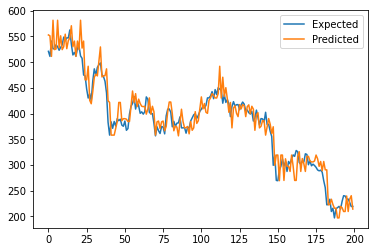

In [53]:
values=BNB[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [54]:
bnb_merge_data = pd.DataFrame({ 
                            'open': BNB['open'],
                            'rsi': BNB['rsi'],
                            'rs': BNB['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'finance_sentiment': finance_news.sentiment_score,
                            'coindesk_sentiment': coindesk_news.sentiment_score,
                            'adj close': BNB['adj close']
                          })

MAE: 14.849


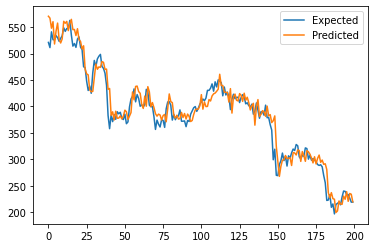

In [55]:
values=bnb_merge_data[['crypto_sentiment','stock_market_sentiment','finance_sentiment','coindesk_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)